In [2]:
import warnings
warnings.filterwarnings("ignore")

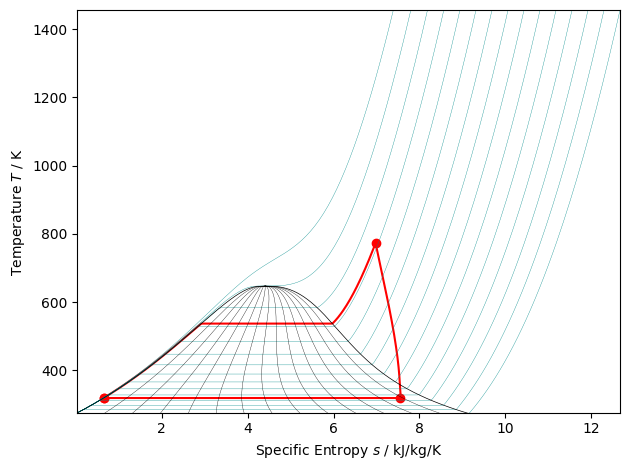

In [3]:
import CoolProp
from CoolProp.CoolProp import PropsSI
from CoolProp.Plots.SimpleCycles import StateContainer, BaseCycle
from CoolProp.Plots import PropertyPlot
import matplotlib.pyplot as plt

class SimpleRankineCycle(BaseCycle):
    """
    Class to compute and store thermodynamic states for a simple Rankine cycle without reheating.
    """
    STATECOUNT = 4
    STATECHANGE = [
        lambda inp: BaseCycle.state_change(inp, 'S', 'P', 0, ty1='log', ty2='log'),  # Pumping process
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 1, ty1='lin', ty2='lin'),  # Heat addition (boiler)
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 2, ty1='log', ty2='log'),  # Turbine expansion
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 3, ty1='lin', ty2='lin')   # Condenser heat removal
    ]

    def __init__(self, fluid, eta_turbine, eta_pump, graph_type="TS", **kwargs):
        """
        Initialize the simple Rankine cycle.

        Parameters:
        -----------
        fluid : str
            Working fluid (e.g., 'Water').
        eta_turbine : float
            Isentropic efficiency of the turbine.
        eta_pump : float
            Isentropic efficiency of the pump.
        """
        self.eta_turbine = eta_turbine
        self.eta_pump = eta_pump
        self.fluid_ref = fluid
        super().__init__(fluid, graph_type, **kwargs)

    def simple_solve(self, p_high, T_high, p_cond, q_cond, SI=True):
        """
        Solve the thermodynamic states for a simple Rankine cycle.

        Parameters:
        -----------
        p_high : float
            Boiler pressure (Pa).
        T_high : float
            Boiler temperature (K).
        p_cond : float
            Condenser pressure (Pa).
        q_cond : float
            Quality at the condenser outlet (e.g., 0.0 for saturated liquid).
        """
        cycle_states = StateContainer(unit_system=self._system)

        # State 0: Saturated liquid at condenser pressure
        T0 = PropsSI("T", "P", p_cond, "Q", q_cond, self.fluid_ref)
        h0 = PropsSI("H", "P", p_cond, "Q", q_cond, self.fluid_ref)
        s0 = PropsSI("S", "P", p_cond, "Q", q_cond, self.fluid_ref)
        cycle_states[0, 'P'], cycle_states[0, 'T'], cycle_states[0, 'H'], cycle_states[0, 'S'] = p_cond, T0, h0, s0

        # State 1: Pump outlet
        h1_isentropic = PropsSI("H", "P", p_high, "S", s0, self.fluid_ref)
        h1 = h0 + (h1_isentropic - h0) / self.eta_pump
        self.state.update(CoolProp.HmassP_INPUTS, h1, p_high)
        T1 = self.state.T()
        s1 = self.state.smass()
        cycle_states[1, 'P'], cycle_states[1, 'T'], cycle_states[1, 'H'], cycle_states[1, 'S'] = p_high, T1, h1, s1

        # State 2: Turbine inlet
        self.state.update(CoolProp.PT_INPUTS, p_high, T_high)
        h2 = self.state.hmass()
        s2 = self.state.smass()
        cycle_states[2, 'P'], cycle_states[2, 'T'], cycle_states[2, 'H'], cycle_states[2, 'S'] = p_high, T_high, h2, s2

        # State 3: Turbine outlet
        h3_isentropic = PropsSI("H", "P", p_cond, "S", s2, self.fluid_ref)
        h3 = h2 - self.eta_turbine * (h2 - h3_isentropic)
        self.state.update(CoolProp.HmassP_INPUTS, h3, p_cond)
        T3 = self.state.T()
        s3 = self.state.smass()
        cycle_states[3, 'P'], cycle_states[3, 'T'], cycle_states[3, 'H'], cycle_states[3, 'S'] = p_cond, T3, h3, s3

        self.cycle_states = cycle_states
        self.fill_states()

    def eta_thermal(self):
        """
        Calculate the thermal efficiency of the cycle.

        Returns:
        --------
        float
            Thermal efficiency.
        """
        w_net = self.cycle_states[2].H - self.cycle_states[3].H - (self.cycle_states[1].H - self.cycle_states[0].H)
        q_boiler = self.cycle_states[2].H - self.cycle_states[1].H
        return w_net / q_boiler

    def show_plot(self, zoom_compression=False):
        """
        Show the property plot of the Rankine cycle.

        Parameters:
        -----------
        zoom_compression : bool
            If True, zoom into the compression section.
        """
        # Retrieve and display the states
        self.steps = 200
        halo = self.get_state_changes()

        plot = PropertyPlot(self.fluid_ref, 'TS')
        plot.calc_isolines(CoolProp.iP, num=15)
        plot.calc_isolines(CoolProp.iQ, num=15)
        plot.draw_process(halo)

        if zoom_compression:
            # Zoom into compression region
            range_T = 0.1
            range_s = 0.001
            state_0 = self.cycle_states[0]
            state_1 = self.cycle_states[1]
            s_min = min(state_0['S'], state_1['S'])/1000 - range_s
            s_max = max(state_0['S'], state_1['S'])/1000 + range_s
            T_min = min(state_0['T'], state_1['T']) - range_T
            T_max = max(state_0['T'], state_1['T']) + range_T
            plot.axis.set_xlim([s_min, s_max])
            plot.axis.set_ylim([T_min, T_max])

        plt.close(self.figure)
        plt.ioff()

        # Show the plot
        plot.show()

# Example Usage
if __name__ == "__main__":
    fluid_name = 'Water'
    p_high = 5e6
    T_high = 773.15
    p_cond = 10e3
    q_cond = 0.0

    cycle = SimpleRankineCycle(fluid_name, 0.85, 0.85)
    cycle.simple_solve(p_high, T_high, p_cond, q_cond)
    cycle.show_plot(zoom_compression=False)


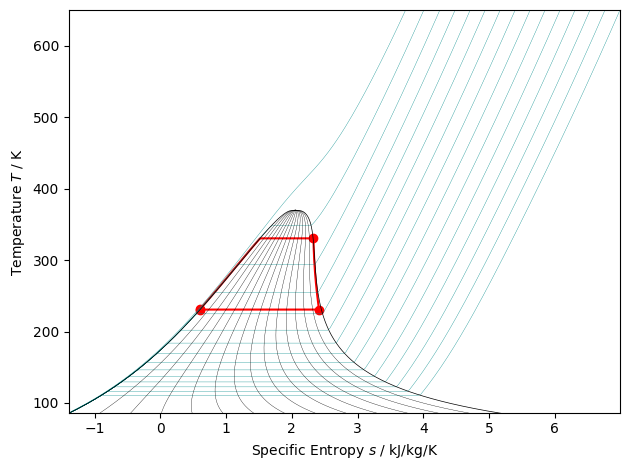

In [4]:
import CoolProp
from CoolProp.CoolProp import PropsSI
from CoolProp.Plots.SimpleCycles import StateContainer, BaseCycle
from CoolProp.Plots import PropertyPlot
import matplotlib.pyplot as plt

class OrganicRankineCycle(BaseCycle):
    """
    Class to compute and store thermodynamic states for an Organic Rankine Cycle (ORC).
    """
    STATECOUNT = 4
    STATECHANGE = [
        lambda inp: BaseCycle.state_change(inp, 'S', 'P', 0, ty1='log', ty2='log'),  # Pumping process
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 1, ty1='lin', ty2='lin'),  # Heat addition (boiler)
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 2, ty1='log', ty2='log'),  # Turbine expansion
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 3, ty1='lin', ty2='lin')   # Condenser heat removal
    ]

    def __init__(self, fluid, eta_turbine, eta_pump, graph_type="TS", **kwargs):
        """
        Initialize the Organic Rankine Cycle (ORC).

        Parameters:
        -----------
        fluid : str
            Working fluid (e.g., 'R245fa').
        eta_turbine : float
            Isentropic efficiency of the turbine.
        eta_pump : float
            Isentropic efficiency of the pump.
        """
        self.eta_turbine = eta_turbine
        self.eta_pump = eta_pump
        self.fluid_ref = fluid
        super().__init__(fluid, graph_type, **kwargs)

    def simple_solve(self, p_high, T_high, p_cond, q_cond, SI=True):
        """
        Solve the thermodynamic states for the Organic Rankine Cycle.

        Parameters:
        -----------
        p_high : float
            Boiler pressure (Pa).
        T_high : float
            Boiler temperature (K).
        p_cond : float
            Condenser pressure (Pa).
        q_cond : float
            Quality at the condenser outlet (e.g., 0.0 for saturated liquid).
        """
        cycle_states = StateContainer(unit_system=self._system)

        # State 0: Saturated liquid at condenser pressure
        T0 = PropsSI("T", "P", p_cond, "Q", q_cond, self.fluid_ref)
        h0 = PropsSI("H", "P", p_cond, "Q", q_cond, self.fluid_ref)
        s0 = PropsSI("S", "P", p_cond, "Q", q_cond, self.fluid_ref)
        cycle_states[0, 'P'], cycle_states[0, 'T'], cycle_states[0, 'H'], cycle_states[0, 'S'] = p_cond, T0, h0, s0

        # State 1: Pump outlet
        h1_isentropic = PropsSI("H", "P", p_high, "S", s0, self.fluid_ref)
        h1 = h0 + (h1_isentropic - h0) / self.eta_pump
        self.state.update(CoolProp.HmassP_INPUTS, h1, p_high)
        T1 = self.state.T()
        s1 = self.state.smass()
        cycle_states[1, 'P'], cycle_states[1, 'T'], cycle_states[1, 'H'], cycle_states[1, 'S'] = p_high, T1, h1, s1

        # State 2: Turbine inlet
        self.state.update(CoolProp.PT_INPUTS, p_high, T_high)
        h2 = self.state.hmass()
        s2 = self.state.smass()
        cycle_states[2, 'P'], cycle_states[2, 'T'], cycle_states[2, 'H'], cycle_states[2, 'S'] = p_high, T_high, h2, s2

        # State 3: Turbine outlet
        h3_isentropic = PropsSI("H", "P", p_cond, "S", s2, self.fluid_ref)
        h3 = h2 - self.eta_turbine * (h2 - h3_isentropic)
        self.state.update(CoolProp.HmassP_INPUTS, h3, p_cond)
        T3 = self.state.T()
        s3 = self.state.smass()
        cycle_states[3, 'P'], cycle_states[3, 'T'], cycle_states[3, 'H'], cycle_states[3, 'S'] = p_cond, T3, h3, s3

        self.cycle_states = cycle_states
        self.fill_states()

    def eta_thermal(self):
        """
        Calculate the thermal efficiency of the cycle.

        Returns:
        --------
        float
            Thermal efficiency.
        """
        w_net = self.cycle_states[2].H - self.cycle_states[3].H - (self.cycle_states[1].H - self.cycle_states[0].H)
        q_boiler = self.cycle_states[2].H - self.cycle_states[1].H
        return w_net / q_boiler

    def show_plot(self, zoom_compression=False):
        """
        Show the property plot of the Organic Rankine Cycle.

        Parameters:
        -----------
        zoom_compression : bool
            If True, zoom into the compression section.
        """
        # Retrieve and display the states
        self.steps = 200
        halo = self.get_state_changes()

        plot = PropertyPlot(self.fluid_ref, 'TS')
        plot.calc_isolines(CoolProp.iP, num=15)
        plot.calc_isolines(CoolProp.iQ, num=15)
        plot.draw_process(halo)

        if zoom_compression:
            # Zoom into compression region
            range_T = 0.1
            range_s = 0.001
            state_0 = self.cycle_states[0]
            state_1 = self.cycle_states[1]
            s_min = min(state_0['S'], state_1['S']) / 1000 - range_s  # Convert entropy to specific entropy
            s_max = max(state_0['S'], state_1['S']) / 1000 + range_s  # Convert entropy to specific entropy
            T_min = min(state_0['T'], state_1['T']) - range_T
            T_max = max(state_0['T'], state_1['T']) + range_T
            plot.axis.set_xlim([s_min, s_max])
            plot.axis.set_ylim([T_min, T_max])

        plt.close(self.figure)
        plt.ioff()

        # Show the plot
        plot.show()

# Example Usage
if __name__ == "__main__":
    fluid_name = 'n-Propane'
    p_high = 2e6
    T_high = 331
    p_cond = 1e5
    q_cond = 0.0

    cycle = OrganicRankineCycle(fluid_name, 0.85, 0.85)
    cycle.simple_solve(p_high, T_high, p_cond, q_cond)
    cycle.show_plot(zoom_compression=False)


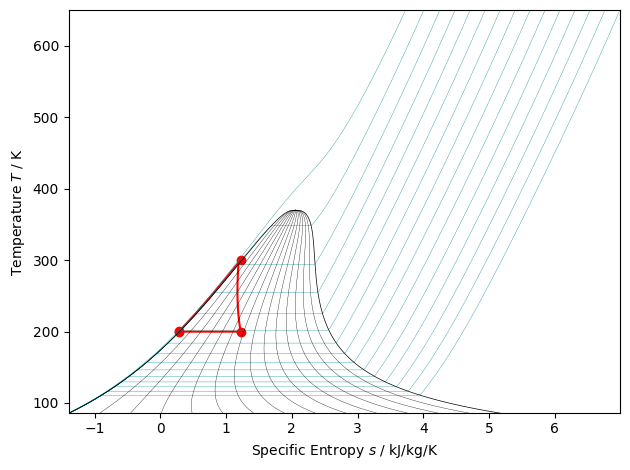

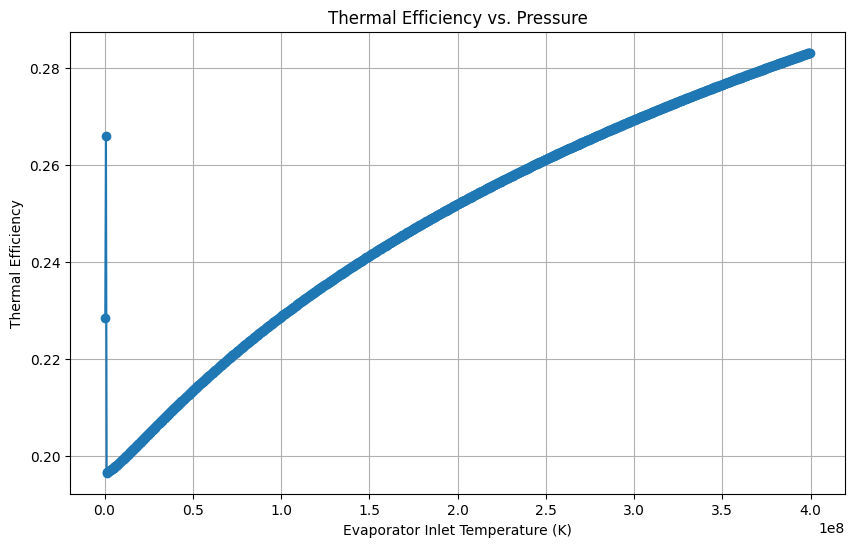

In [ ]:
import CoolProp
from CoolProp.CoolProp import PropsSI
from CoolProp.Plots.SimpleCycles import StateContainer, BaseCycle
from CoolProp.Plots import PropertyPlot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

class TrilateralFlashCycle(BaseCycle):
    """
    Class to compute and store thermodynamic states for a Trilateral Flash Cycle (TFC).
    """
    STATECOUNT = 4
    STATECHANGE = [
        lambda inp: BaseCycle.state_change(inp, 'S', 'P', 0, ty1='log', ty2='log'),  # Pumping process
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 1, ty1='lin', ty2='lin'),  # Heat addition (evaporator)
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 2, ty1='log', ty2='log'),  # Turbine expansion
        lambda inp: BaseCycle.state_change(inp, 'H', 'P', 3, ty1='lin', ty2='lin')   # Condenser heat removal
    ]

    def __init__(self, fluid, eta_turbine, eta_pump, graph_type="TS", **kwargs):
        """
        Initialize the Trilateral Flash Cycle (TFC).

        Parameters:
        -----------
        fluid : str
            Working fluid (e.g., 'R134a').
        eta_turbine : float
            Isentropic efficiency of the turbine.
        eta_pump : float
            Isentropic efficiency of the pump.
        """
        self.eta_turbine = eta_turbine
        self.eta_pump = eta_pump
        self.fluid_ref = fluid
        super().__init__(fluid, graph_type, **kwargs)

    def simple_solve(self, p_high, T_evap_in, T_evap_out, p_cond, q_cond, SI=True):
        """
        Solve the thermodynamic states for the Trilateral Flash Cycle.

        Parameters:
        -----------
        p_high : float
            Evaporator pressure (Pa).
        T_evap_in : float
            Inlet temperature to the evaporator (K).
        T_evap_out : float
            Outlet temperature from the evaporator (K).
        p_cond : float
            Condenser pressure (Pa).
        q_cond : float
            Quality at the condenser outlet (e.g., 0.0 for saturated liquid).
        """
        cycle_states = StateContainer(unit_system=self._system)

        # State 0: Saturated liquid at condenser pressure
        T0 = PropsSI("T", "P", p_cond, "Q", q_cond, self.fluid_ref)
        h0 = PropsSI("H", "P", p_cond, "Q", q_cond, self.fluid_ref)
        s0 = PropsSI("S", "P", p_cond, "Q", q_cond, self.fluid_ref)
        cycle_states[0, 'P'], cycle_states[0, 'T'], cycle_states[0, 'H'], cycle_states[0, 'S'] = p_cond, T0, h0, s0

        # State 1: Pump outlet
        h1_isentropic = PropsSI("H", "P", p_high, "S", s0, self.fluid_ref)
        h1 = h0 + (h1_isentropic - h0) / self.eta_pump
        self.state.update(CoolProp.HmassP_INPUTS, h1, p_high)
        T1 = self.state.T()
        s1 = self.state.smass()
        cycle_states[1, 'P'], cycle_states[1, 'T'], cycle_states[1, 'H'], cycle_states[1, 'S'] = p_high, T1, h1, s1

        # State 2: Evaporator outlet
        self.state.update(CoolProp.PT_INPUTS, p_high, T_evap_out)
        h2 = self.state.hmass()
        s2 = self.state.smass()
        cycle_states[2, 'P'], cycle_states[2, 'T'], cycle_states[2, 'H'], cycle_states[2, 'S'] = p_high, T_evap_out, h2, s2

        # State 3: Turbine outlet
        h3_isentropic = PropsSI("H", "P", p_cond, "S", s2, self.fluid_ref)
        h3 = h2 - self.eta_turbine * (h2 - h3_isentropic)
        self.state.update(CoolProp.HmassP_INPUTS, h3, p_cond)
        T3 = self.state.T()
        s3 = self.state.smass()
        cycle_states[3, 'P'], cycle_states[3, 'T'], cycle_states[3, 'H'], cycle_states[3, 'S'] = p_cond, T3, h3, s3

        self.cycle_states = cycle_states
        self.fill_states()

    def eta_thermal(self):
        """
        Calculate the thermal efficiency of the cycle.

        Returns:
        --------
        float
            Thermal efficiency.
        """
        w_net = self.cycle_states[2].H - self.cycle_states[3].H - (self.cycle_states[1].H - self.cycle_states[0].H)
        q_evap = self.cycle_states[2].H - self.cycle_states[1].H
        return w_net / q_evap

    def show_plot(self, zoom_compression=False):
        """
        Show the property plot of the Trilateral Flash Cycle.

        Parameters:
        -----------
        zoom_compression : bool
            If True, zoom into the compression section.
        """
        # Retrieve and display the states
        self.steps = 200
        halo = self.get_state_changes()

        plot = PropertyPlot(self.fluid_ref, 'TS')
        plot.calc_isolines(CoolProp.iP, num=15)
        plot.calc_isolines(CoolProp.iQ, num=15)
        plot.draw_process(halo)

        if zoom_compression:
            # Zoom into compression region
            range_T = 0.1
            range_s = 0.001
            state_0 = self.cycle_states[0]
            state_1 = self.cycle_states[1]
            s_min = min(state_0['S'], state_1['S']) / 1000 - range_s  # Convert entropy to specific entropy
            s_max = max(state_0['S'], state_1['S']) / 1000 + range_s  # Convert entropy to specific entropy
            T_min = min(state_0['T'], state_1['T']) - range_T
            T_max = max(state_0['T'], state_1['T']) + range_T
            plot.axis.set_xlim([s_min, s_max])
            plot.axis.set_ylim([T_min, T_max])

        plt.close(self.figure)
        plt.ioff()

        # Show the plot
        plot.show()

    def plot_efficiency_vs_temperature(self, p_high, T_range, T_evap_out, p_cond, q_cond):
        """
        Plot efficiency vs. varying evaporator inlet temperature.

        Parameters:
        -----------
        p_high : float
            Evaporator pressure (Pa).
        T_range : list
            Range of inlet temperatures to evaluate (K).
        T_evap_out : float
            Outlet temperature from the evaporator (K).
        p_cond : float
            Condenser pressure (Pa).
        q_cond : float
            Quality at the condenser outlet (e.g., 0.0 for saturated liquid).
        """
        efficiencies = []
        for T_evap_in in T_range:
            self.simple_solve(p_high, T_evap_in, T_evap_out, p_cond, q_cond)
            efficiencies.append(self.eta_thermal())

        plt.figure()
        plt.plot(T_range, efficiencies, marker='o')
        plt.xlabel('Evaporator Inlet Temperature (K)')
        plt.ylabel('Thermal Efficiency')
        plt.title('Thermal Efficiency vs. Evaporator Inlet Temperature')
        plt.grid(True)
        plt.show()

    def plot_efficiency_vs_pressure(self, p_range, T_evap_in, T_evap_out, p_cond, q_cond):
        """
        Plot efficiency vs. varying evaporator pressure.

        Parameters:
        -----------
        p_range : list
            Range of evaporator pressures to evaluate (Pa).
        T_evap_in : float
            Inlet temperature to the evaporator (K).
        T_evap_out : float
            Outlet temperature from the evaporator (K).
        p_cond : float
            Condenser pressure (Pa).
        q_cond : float
            Quality at the condenser outlet (e.g., 0.0 for saturated liquid).
        """
        efficiencies = []
        for p_high in p_range:
            self.simple_solve(p_high, T_evap_in, T_evap_out, p_cond, q_cond)
            efficiencies.append(self.eta_thermal())

        plt.figure()
        plt.plot(p_range, efficiencies, marker='o')
        plt.xlabel('Evaporator Pressure (Pa)')
        plt.ylabel('Thermal Efficiency')
        plt.title('Thermal Efficiency vs. Evaporator Pressure')
        plt.grid(True)
        plt.show()

# Example Usage
if __name__ == "__main__":
    fluid_name = 'n-Propane'
    p_high = 4e6
    T_evap_in = 200
    T_evap_out = 300
    q_cond = 0.0
    p_cond = 2e4

    cycle = TrilateralFlashCycle(fluid_name, 1, 1)
    cycle.simple_solve(p_high, T_evap_in, T_evap_out, p_cond, q_cond)
    cycle.show_plot(zoom_compression=False)
    
    

    # # Example: Plot efficiency vs. temperature
    # T_range = [300.15, 310.15, 320.15, 330.15, 340.15]
    # cycle.plot_efficiency_vs_temperature(p_high, T_range, T_evap_out, p_cond, q_cond)

    # # Example: Plot efficiency vs. pressure
    # p_range = [p_high * 0.75, p_high, p_high * 1.25, p_high * 1.5, p_high * 1.75]
    # p_range = [i*p_high/10 for i in range(1, 100)]
    # cycle.plot_efficiency_vs_pressure(p_range, T_evap_in, T_evap_out, p_cond, q_cond)
    # Plot efficiency vs. temperature
    # T_range = [i*10 + T_evap_in for i in range(1, 100)]
    p_range = [i*p_high/10 for i in range(1, 1000)]
    efficiencies = []

    for p_high in p_range:
        cycle.simple_solve(p_high, T_evap_in, T_evap_out, p_cond, q_cond)
        efficiencies.append(cycle.eta_thermal())
    # for T_evap_in in T_range:
    #     cycle.simple_solve(p_high, T_evap_in, T_evap_out, p_cond, q_cond)
    #     efficiencies.append(cycle.eta_thermal())

    plt.figure(figsize=(10, 6))
    plt.plot(p_range, efficiencies, marker='o')
    # plt.xlabel('Evaporator Inlet Temperature (K)')
    plt.xlabel('P')
    plt.ylabel('Thermal Efficiency')
    plt.title('Thermal Efficiency vs. Pressure')
    plt.grid(True)
    plt.show()